# Data Mining and Preprocessing

## Данные опросов населения Нидерландов о мобильности

Данные опросов населения Нидерландов изначально представлены в формате данных SPSS и являются результатами двух социологических исследований -- MON и OViN. При этом исследование OViN является достаточно стабильным по структуре и набору переменных, в то время как MON является переходной формой исследования от OVD (1985-2003) к OViN (2009 - н.в.)
Исходя из изменчивости структуры, а также необходимости перевода нидерландскоязычных данных на русский язык проводилась предварительная подготовка данных. Она залючалась в:

- переводе нидерландскоязычных названий переменных в удобный для последующей обработки вид
- присвоении текстовых значений на русском языке категориальным переменным, кодированным целыми числами в таблице
- приведении имен колонок данных MON и OVIN в единый вид

### Импорт данных и библиотек

In [1]:
import pandas as pd
from pyreadstat import pyreadstat
from collections import defaultdict, OrderedDict
import os
from tqdm import tqdm
import json
import re
import geopandas as gpd
from shapely.geometry import Point
import requests

In [2]:
os.chdir('D:/bachelors/datasets/')

In [17]:
df.rename(columns = mapper_columns).to_excel('D:/bachelors/data_venes_renamed_columns.xlsx')

In [3]:
path_MON = 'D:/bachelors/datasets/MobNed_dat/'
path_OViN = 'D:/bachelors/datasets/OViN_dat/'
# path_OViN = 'D:/bachelors/datasets/ODiN_dat/'

l_dir_MON = os.listdir(path_MON)
l_dir_OViN = os.listdir(path_OViN)


iterator = {
    'MON' : {'path' : path_MON,
             'list_dir' : l_dir_MON},
    'OViN' : {'path' : path_OViN,
              'list_dir' : l_dir_OViN}
}

### Выгрузка метаданных из таблиц SPSS для последющего перевода и отбора значений

In [4]:
def get_variables(meta, variables):
    """
    returns metadataframe extracted from MON or OViN data
    """
    current_meta = pd.DataFrame({
        'variable' : meta.column_names,
        'description' : meta.column_labels
    }).assign(
        variable = lambda x: x['variable'].str.lower(),
        description = lambda x: x['description'].str.lower()
    )
    current_meta = current_meta[~current_meta.variable.isin(variables.variable)]
    print(len(current_meta))
    
    return current_meta

In [5]:
def get_values(variables_dict):
    """
    returns values labels in dutch language to use in further translation
    """
    values = pd.DataFrame()
    for var in tqdm(variables_dict):
        current_var_map = variables_dict[var]
        values = values.append(pd.DataFrame({
            'variable' : [var for i in current_var_map.keys()],
            'values' : list(current_var_map.keys()),
            'meaning' : list(current_var_map.values())
       }))
        values['variable'] = values.variable.str.lower()
        
    return values

In [ ]:
variables_table = OrderedDict()
for data in iterator:
    variables_values = OrderedDict()
    l_dir = iterator[data]['list_dir']
    root_path = iterator[data]['path']
    variables = pd.DataFrame(columns = ['variable', 'description'])
    
    for l in tqdm(l_dir):
        meta = pyreadstat.read_sav(root_path + l)[1]
        variables = variables.append(get_variables(meta, variables))
        
        variables_values[l.split('.')[0]] = get_values(meta.variable_value_labels)
        
    variables_table[data] = variables
    
    writer = pd.ExcelWriter(f'D:/bachelors/datasets/Variables/{data}_labels.xlsx')
    for sheet in variables_values:
        variables_values[sheet].to_excel(writer, sheet_name = sheet, index = False)
    writer.save()
    
    
writer = pd.ExcelWriter('D:/bachelors/datasets/Variables/variables_descriptions.xlsx')
for sheet in variables_table:
    variables_table[sheet].to_excel(writer, sheet_name = sheet, index = False)
writer.save()

### Создание словарей для переименования и отбора колонок

Экспортированные в результате получения метаданных преобразовывались и переводились, в результате чего названия колонок были переведены английский язык для удобства испоользования. После этого началось создание словарей, которые использовались для перевода колонок

In [7]:
variables_MON = pd.read_excel(r"Variables\variables descriptions_edited.xlsx", sheet_name = 'MON').dropna()
variables_OViN = pd.read_excel(r"Variables\variables descriptions_edited.xlsx", sheet_name = 'OViN').dropna()
# variables_ODiN = pd.read_excel(r"Variables\variables descriptions_edited.xlsx", sheet_name = 'ODiN').dropna()

In [9]:
columns_mapper = {
    'MON' : dict(zip(variables_MON.variable, variables_MON.eng_name)),
    'OViN' : dict(zip(variables_OViN.variable, variables_OViN.eng_name))
#     'ODiN' : dict(zip(variables_ODiN.variable, variables_ODiN.eng_name))  
}

with open('D:/bachelors/datasets/Variables/mappers/columns_mappers.json', 'w') as outfile:
    json.dump(columns_mapper, outfile)

In [17]:
# if `columns_mapper` is not loaded
with open ('Variables/mappers/columns_mappers.json') as infile:
    columns_mapper = json.load(infile)

In [34]:
df, meta = pyreadstat.read_sav('OViN_dat/OViN2014_Databestand.sav')
df.columns = [i.lower() for i in df.columns]
df = df.drop(columns = list(set(df.columns).difference(columns_mapper['OViN'].keys())))
df = df.rename(columns = columns_mapper['OViN'])

In [147]:
def filter_values(values_dict, database_source):
    """
    Selects required columns and maps them with convinient to use names
    """
    new_values = OrderedDict()
    for sheet in values_dict:
        print(sheet)
        current_labels = values_dict[sheet]
        new_values[sheet] = current_labels[
            current_labels.variable.isin(
                columns_mapper[database_source].keys()
            )
        ].assign(
            variable = lambda x: x['variable'].map(columns_mapper[database_source])
        )
        
    return new_values

In [148]:
values_MON_filtered = filter_values(
    pd.read_excel('Variables/MON_labels.xlsx', sheet_name = None),
    'MON'
)

values_OViN_filtered = filter_values(
    pd.read_excel('Variables/OViN_labels.xlsx', sheet_name = None),
    'OViN'
)

values_ODiN_filtered = filter_values(
    pd.read_excel('Variables/ODiN_labels.xlsx', sheet_name = None),
    'ODiN'
)

Databestand MON 2004
Databestand MON 2005
Databestand MON 2006
Databestand MON 2007
Databestand MON 2008
Databestand MON 2009
OViN2010_Databestand
OViN2011_Databestand_revisie
OViN2012_Databestand_revisie
OViN2013_Databestand
OViN2014_Databestand
OViN2015_Databestand
OViN2016_Databestand
OViN2017_Databestand


In [13]:
def write_excel_multi(odict, path):
    """
    Writes an ordered dictionary of dataframes to the multipage excel spreadsheet
    """
    writer = pd.ExcelWriter(path)
    for sheet in odict:
        odict[sheet].to_excel(writer, sheet_name = sheet, index = False)
    writer.save()

In [14]:
write_excel_multi(values_MON_filtered, 'Variables/MON_Variables_values_v2.xlsx')
write_excel_multi(values_OViN_filtered, 'Variables/OViN_Variables_values_v2.xlsx')
write_excel_multi(values_OViN_filtered, 'Variables/ODiN_Variables_values_v2.xlsx')

## Словари для переименования значений переменных

In [10]:
MON_values_map = pd.read_excel('Variables/mappers/MON_Variables_values_to_mappers_v2.xlsx', sheet_name = None)
OViN_values_map = pd.read_excel('Variables/mappers/OViN_Variables_values_to_mappers_v2.xlsx', sheet_name = None)
# ODiN_values_map = pd.read_excel('Variables/mappers/ODiN_Variables_values_to_mappers_v2.xlsx', sheet_name = None)

In [22]:
d = MON_values_map['Databestand MON 2009']
d[d.variable == 'geo_arrival']

,variable,values,meaning,mapped
1199,geo_arrival,0,Aankomstpunt in buitenland,NaN
1200,geo_arrival,3,Appingedam,Appingedam
1201,geo_arrival,5,Bedum,Bedum
1202,geo_arrival,7,Bellingwedde,Bellingwedde
1203,geo_arrival,9,TenBoer,Ten Boer
1204,geo_arrival,10,Delfzijl,Delfzijl
1205,geo_arrival,14,Groningen,Groningen
1206,geo_arrival,15,Grootegast,Grootegast
1207,geo_arrival,17,Haren,Haren
1208,geo_arrival,18,Hoogezand-Sappemeer,Hoogezand-Sappemeer


In [23]:
values_map = {
    'MON' : defaultdict(dict),
    'OViN' : defaultdict(dict),
#     'ODiN' : defaultdict(dict)
}

In [24]:
for sheet in MON_values_map:
    current_mapper = MON_values_map[sheet]
    
    for var in current_mapper.variable.unique().tolist():
        current_variable = current_mapper[current_mapper.variable == var]
        values_map['MON'][sheet][var] = dict(zip(current_variable['values'], current_variable['mapped']))

In [25]:
for sheet in OViN_values_map:
    current_mapper = OViN_values_map[sheet]
    
    for var in current_mapper.variable.unique().tolist():
        current_variable = current_mapper[current_mapper.variable == var]
        values_map['OViN'][sheet][var] = dict(zip(current_variable['values'], current_variable['mapped']))

In [ ]:
for sheet in ODiN_values_map:
    current_mapper = ODiN_values_map[sheet]
    
    for var in current_mapper.variable.unique().tolist():
        current_variable = current_mapper[current_mapper.variable == var]
        values_map['ODiN'][sheet][var] = dict(zip(current_variable['values'], current_variable['mapped']))

In [26]:
with open('Variables/mappers/values_ru_map_v2.json', 'w') as outfile:
    json.dump(values_map, outfile)

In [27]:
with open('Variables/mappers/values_ru_map_v2.json') as infile:
    values_map = json.load(infile)

### Перевод данных и их экспорт

После подготовки словарей, был произведен перевод значений переменных внутри таблиц данных и фильтрация колонок, пригодных для использования в качестве статичных годовых слоев с социально-экономическими характеристиками территории. 

In [28]:
import re

In [29]:
for data in iterator:
    colnames = columns_mapper[data]
    colnames.pop('hsnor', None) # on the fly fixing of mistakes in colnames data (they had two different columns for mopeds)
    colnames.pop('hhsnor', None)
    colnames.pop('psnor', None)
    colnames.pop('opsnor', None)
    valuesMap = values_map[data]
    l_dir = iterator[data]['list_dir']
    root_path = iterator[data]['path']
    for l in tqdm(l_dir):
        df = pyreadstat.read_sav(root_path + l)[0]
        df.columns = [i.lower() for i in df.columns]
        
        true_keys = list(set(df.columns).intersection(set(colnames.keys())))
        mapper = {k : colnames[k] for k in true_keys}
        
        df = df[list(mapper.keys())].rename(columns = mapper).astype(int, errors = 'ignore')
        current_df_values = valuesMap[l.split('.')[0]]

        for col in list(current_df_values.keys()):
            if (col in ['geo_departure', 'geo_arrival']) and (len(current_df_values[col]) < 100):
                df.loc[
                    df[col].isin(current_df_values['geo_commune'].keys()), col
                ] = df.loc[
                    df[col].isin(current_df_values['geo_commune'].keys()), col
                ].astype(int).astype(str).map(current_df_values['geo_commune'])
            else:
                df.loc[
                    df[col].isin(current_df_values[col].keys()), col
                ] = df.loc[
                    df[col].isin(current_df_values[col].keys()), col
                ].astype(int).astype(str).map(current_df_values[col])
        year = re.findall('\d+', l)[0]
        df['uid_person'] = [i for i in range(len(df))]
        df.to_csv(f'translated_data_v2/data_{year}.csv', index = None)

100%|██████████| 8/8 [01:55<00:00, 14.00s/it]


## Геокодирование коммун

Исходные данные имеют географическую привязку в виде почтовых индексов, коммун, регионов COROP и провинций Нидерландов. Поскольку в качестве операционной ячейки использовались коммуны, то далее производилось их прямое геокодирование (преобразование адресов в географические координаты)

In [23]:
datasets = defaultdict(list)

In [24]:
for y in range(2004, 2018):
    datasets[str(y)] = pd.read_csv(f'translated_data/data_{y}.csv')

C:\Users\mtopn\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (7,13,18,25,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
def getCommunes(df):
    """
    Returns the set of unique communes
    """
    list_sets = [set(df.geo_arrival.dropna()),
                 set(df.geo_departure.dropna()),
                 set(df.geo_commune.dropna())]
    return set().union(*list_sets)

In [ ]:
communes_set = set()
for dset in datasets:
    communes_set = communes_set.union(getCommunes(datasets[dset]))
    
communes = pd.DataFrame({'commune' : list(communes_set)})
communes['address'] = communes.commune.apply(lambda x: x + ', Netherlands')
communes['lat'], communes['lon'] = pd.Series(), pd.Series()

In [87]:
import googlemaps

gmaps = googlemaps.Client(key='')

In [88]:
communes.head()

,commune,address,lat,lon
0,Maasbree,"Maasbree, Netherlands",51.363428,6.050578
1,Goirle,"Goirle, Netherlands",51.523958,5.066198
2,Arcenen Velden,"Arcenen Velden, Netherlands",NaN,NaN
3,Vlaardingen,"Vlaardingen, Netherlands",51.922786,4.329563
4,I Jsselstein,"I Jsselstein, Netherlands",NaN,NaN


In [90]:
most_relevant = gmaps.geocode('uglich, russia')[0]

In [95]:
most_relevant['geometry']['location']

{'lat': 57.52478960000001, 'lng': 38.3308361}

In [98]:
def gcode_gmaps(location):
    try:
        response = gmaps.geocode(location)
        most_relevant = response[0]
        location = most_relevant['geometry']['location']
        
        return location['lat'], location['lng'], response
    except Exception as e:
        print(e)
        return None, None, response

In [99]:
responses = defaultdict(dict)
for i, row in tqdm(communes.iterrows()):
    location = row['address']
    lat, lon, response = gcode_gmaps(location)
#     sleep(1)
    
    responses[row['commune']] = response
    
    communes.loc[communes.address == location, 'lat'] = lat
    communes.loc[communes.address == location, 'lon'] = lon
    
with open('communes_responses_google.json', 'w') as outfile:
    json.dump(responses, outfile)


0it [00:00, ?it/s]
1it [00:00,  8.62it/s]
3it [00:00, 10.36it/s]
6it [00:00, 12.53it/s]
8it [00:00, 14.10it/s]
10it [00:01,  6.99it/s]
12it [00:01,  5.90it/s]
13it [00:01,  4.92it/s]

list index out of range



14it [00:02,  4.11it/s]
15it [00:02,  3.98it/s]
16it [00:02,  3.96it/s]
17it [00:02,  4.15it/s]
18it [00:03,  4.09it/s]
19it [00:03,  3.27it/s]
20it [00:03,  3.42it/s]
21it [00:04,  2.98it/s]
22it [00:05,  1.92it/s]
23it [00:05,  1.94it/s]
24it [00:05,  2.31it/s]
25it [00:06,  2.68it/s]
26it [00:06,  2.67it/s]
27it [00:06,  3.01it/s]
28it [00:07,  3.25it/s]
29it [00:07,  3.40it/s]
30it [00:07,  3.53it/s]
31it [00:07,  3.73it/s]

list index out of range



32it [00:08,  3.67it/s]
33it [00:08,  3.85it/s]
34it [00:08,  3.91it/s]
35it [00:09,  2.59it/s]
36it [00:09,  2.94it/s]
37it [00:09,  3.17it/s]
38it [00:09,  3.48it/s]
39it [00:10,  3.68it/s]
40it [00:10,  3.74it/s]
41it [00:10,  3.06it/s]
42it [00:11,  3.36it/s]
43it [00:11,  3.47it/s]
44it [00:11,  3.54it/s]
45it [00:12,  3.50it/s]
46it [00:12,  2.72it/s]
47it [00:12,  3.00it/s]
48it [00:13,  2.97it/s]
49it [00:13,  3.24it/s]
50it [00:13,  3.34it/s]
51it [00:13,  3.53it/s]
52it [00:14,  3.71it/s]
53it [00:14,  3.16it/s]
54it [00:14,  3.39it/s]
55it [00:15,  3.60it/s]
56it [00:15,  3.81it/s]
57it [00:15,  3.03it/s]
58it [00:15,  3.45it/s]
59it [00:16,  3.74it/s]
60it [00:16,  3.86it/s]
61it [00:16,  3.35it/s]
62it [00:17,  3.59it/s]
63it [00:17,  3.83it/s]
64it [00:17,  3.10it/s]
65it [00:18,  2.67it/s]
66it [00:18,  3.00it/s]
67it [00:18,  3.15it/s]
68it [00:19,  3.32it/s]
69it [00:19,  2.78it/s]
70it [00:19,  3.09it/s]
71it [00:20,  3.34it/s]
72it [00:20,  3.53it/s]
73it [00:20,  3

list index out of range



131it [00:37,  2.72it/s]
132it [00:37,  2.71it/s]
133it [00:37,  3.07it/s]
134it [00:38,  2.84it/s]
135it [00:38,  3.12it/s]
136it [00:38,  3.26it/s]
137it [00:38,  3.47it/s]
138it [00:39,  3.51it/s]
139it [00:39,  3.11it/s]
140it [00:39,  3.36it/s]
141it [00:40,  3.64it/s]
142it [00:40,  3.88it/s]
143it [00:40,  4.06it/s]
144it [00:40,  3.61it/s]
145it [00:41,  3.74it/s]
146it [00:41,  3.88it/s]
147it [00:41,  3.74it/s]

list index out of range



148it [00:42,  3.49it/s]
149it [00:42,  3.67it/s]
150it [00:42,  3.76it/s]
151it [00:42,  3.08it/s]
152it [00:43,  3.38it/s]
153it [00:43,  3.45it/s]
154it [00:43,  3.57it/s]
155it [00:43,  3.70it/s]
156it [00:44,  3.84it/s]
157it [00:44,  3.68it/s]
158it [00:44,  3.82it/s]
159it [00:45,  3.83it/s]
160it [00:45,  4.03it/s]
161it [00:45,  2.94it/s]
162it [00:46,  3.15it/s]
163it [00:46,  3.51it/s]
164it [00:46,  3.64it/s]
165it [00:46,  3.15it/s]
166it [00:47,  3.39it/s]
167it [00:47,  2.98it/s]
168it [00:47,  3.39it/s]
169it [00:48,  3.43it/s]
170it [00:48,  2.60it/s]
171it [00:48,  3.00it/s]
172it [00:49,  3.12it/s]
173it [00:49,  2.81it/s]
174it [00:49,  3.19it/s]
175it [00:50,  3.41it/s]
176it [00:50,  3.69it/s]
177it [00:50,  3.93it/s]
178it [00:50,  4.00it/s]
179it [00:51,  3.69it/s]
180it [00:51,  3.89it/s]
181it [00:51,  3.29it/s]
182it [00:52,  3.09it/s]
183it [00:52,  3.29it/s]
184it [00:52,  3.44it/s]
185it [00:52,  3.48it/s]
186it [00:53,  3.65it/s]
187it [00:53,  3.41it/s]

list index out of range



199it [00:57,  3.13it/s]
200it [00:57,  3.37it/s]
201it [00:57,  3.47it/s]
202it [00:57,  3.56it/s]
203it [00:58,  3.72it/s]
204it [00:58,  3.64it/s]
205it [00:58,  3.75it/s]
206it [00:59,  3.18it/s]
207it [00:59,  3.43it/s]
208it [00:59,  3.57it/s]
209it [00:59,  3.71it/s]
210it [01:00,  3.84it/s]
211it [01:00,  4.20it/s]
212it [01:00,  3.43it/s]
213it [01:01,  3.37it/s]
214it [01:01,  3.64it/s]
215it [01:01,  3.83it/s]
216it [01:01,  4.02it/s]
217it [01:01,  4.22it/s]
218it [01:02,  4.37it/s]
219it [01:02,  4.46it/s]
220it [01:02,  4.39it/s]
221it [01:02,  4.26it/s]
222it [01:03,  4.22it/s]
223it [01:03,  3.40it/s]
224it [01:03,  3.56it/s]
225it [01:03,  3.73it/s]
226it [01:04,  3.81it/s]
227it [01:04,  3.18it/s]
228it [01:04,  3.43it/s]
229it [01:05,  3.05it/s]
230it [01:05,  3.18it/s]
231it [01:05,  3.26it/s]
232it [01:06,  2.93it/s]
233it [01:06,  3.15it/s]
234it [01:06,  3.44it/s]
235it [01:07,  3.73it/s]
236it [01:07,  3.96it/s]
237it [01:07,  3.80it/s]
238it [01:07,  3.90it/s]

list index out of range



306it [01:27,  2.89it/s]
307it [01:28,  3.23it/s]
308it [01:28,  3.49it/s]
309it [01:28,  3.72it/s]
310it [01:28,  3.82it/s]
311it [01:29,  4.04it/s]
312it [01:29,  3.48it/s]
313it [01:29,  3.77it/s]
314it [01:29,  3.73it/s]
315it [01:30,  3.84it/s]
316it [01:30,  3.24it/s]
317it [01:30,  3.57it/s]
318it [01:31,  3.75it/s]
319it [01:31,  3.88it/s]
320it [01:31,  4.01it/s]
321it [01:32,  3.17it/s]
322it [01:32,  3.36it/s]
323it [01:32,  3.58it/s]
324it [01:32,  3.78it/s]
325it [01:33,  3.72it/s]
326it [01:33,  3.59it/s]
327it [01:33,  3.73it/s]
328it [01:33,  3.95it/s]
329it [01:34,  3.14it/s]
330it [01:34,  3.06it/s]
331it [01:34,  3.28it/s]
332it [01:35,  2.95it/s]
333it [01:35,  3.25it/s]
334it [01:35,  3.46it/s]
335it [01:36,  3.54it/s]
336it [01:36,  3.92it/s]
337it [01:36,  4.09it/s]
338it [01:36,  3.19it/s]
339it [01:37,  3.31it/s]
340it [01:37,  2.69it/s]
341it [01:37,  3.06it/s]
342it [01:38,  3.36it/s]
343it [01:38,  3.62it/s]
344it [01:38,  3.80it/s]
345it [01:38,  3.96it/s]

list index out of range



354it [01:41,  3.19it/s]
355it [01:41,  3.31it/s]
356it [01:41,  3.49it/s]

list index out of range



357it [01:42,  3.18it/s]
358it [01:42,  2.85it/s]
359it [01:42,  3.21it/s]
360it [01:43,  3.61it/s]
361it [01:43,  3.86it/s]
362it [01:43,  3.14it/s]
363it [01:44,  3.45it/s]
364it [01:44,  3.54it/s]
365it [01:44,  3.42it/s]
366it [01:45,  2.92it/s]
367it [01:45,  3.20it/s]
368it [01:45,  2.77it/s]
369it [01:46,  3.15it/s]
370it [01:46,  3.30it/s]
371it [01:46,  3.08it/s]

list index out of range



372it [01:47,  2.98it/s]
373it [01:47,  3.21it/s]
374it [01:47,  3.29it/s]
375it [01:48,  2.83it/s]
376it [01:48,  3.12it/s]
377it [01:48,  3.53it/s]
378it [01:48,  3.53it/s]
379it [01:49,  3.74it/s]
380it [01:49,  3.79it/s]
381it [01:49,  3.22it/s]
382it [01:49,  3.41it/s]
383it [01:50,  3.38it/s]
384it [01:50,  3.65it/s]
385it [01:50,  3.72it/s]
386it [01:51,  2.93it/s]
387it [01:51,  3.23it/s]
388it [01:51,  2.97it/s]
389it [01:52,  3.25it/s]
390it [01:52,  3.47it/s]
391it [01:52,  3.62it/s]
392it [01:53,  3.10it/s]
393it [01:53,  3.32it/s]
394it [01:53,  3.62it/s]
395it [01:53,  3.79it/s]
396it [01:54,  3.83it/s]
397it [01:54,  3.78it/s]
398it [01:54,  3.82it/s]
399it [01:54,  3.96it/s]
400it [01:54,  4.13it/s]
401it [01:55,  3.72it/s]
402it [01:55,  4.00it/s]
403it [01:55,  4.20it/s]
404it [01:56,  3.28it/s]
405it [01:56,  3.54it/s]
406it [01:56,  3.56it/s]
407it [01:56,  3.75it/s]
408it [01:57,  3.82it/s]
409it [01:57,  3.82it/s]
410it [01:57,  3.25it/s]
411it [01:58,  2.89it/s]

list index out of range



483it [02:17,  3.12it/s]
484it [02:18,  3.32it/s]
485it [02:18,  3.52it/s]
486it [02:18,  3.45it/s]
487it [02:19,  3.68it/s]
488it [02:19,  3.86it/s]
489it [02:19,  4.02it/s]
490it [02:19,  3.65it/s]
491it [02:20,  3.06it/s]
492it [02:20,  3.31it/s]
493it [02:20,  3.54it/s]
494it [02:20,  3.66it/s]
495it [02:21,  3.81it/s]
496it [02:21,  4.04it/s]
497it [02:21,  4.13it/s]
498it [02:22,  3.54it/s]
499it [02:22,  3.74it/s]
500it [02:22,  3.97it/s]
501it [02:23,  2.91it/s]
502it [02:23,  3.26it/s]
503it [02:23,  3.39it/s]
504it [02:23,  3.39it/s]
505it [02:24,  3.69it/s]

list index out of range



506it [02:24,  3.68it/s]
507it [02:24,  3.43it/s]
508it [02:24,  3.48it/s]
509it [02:25,  3.66it/s]
510it [02:25,  3.73it/s]
511it [02:25,  3.30it/s]
512it [02:26,  2.79it/s]
513it [02:26,  2.77it/s]
514it [02:27,  2.81it/s]
515it [02:27,  2.62it/s]
516it [02:27,  2.88it/s]

list index out of range



517it [02:28,  2.64it/s]
518it [02:28,  2.72it/s]
519it [02:28,  3.11it/s]
520it [02:29,  3.05it/s]
521it [02:29,  3.34it/s]
522it [02:29,  2.56it/s]
523it [02:30,  2.47it/s]
524it [02:30,  2.76it/s]
525it [02:31,  2.62it/s]
526it [02:31,  2.47it/s]
527it [02:31,  2.89it/s]
528it [02:31,  3.15it/s]
529it [02:32,  3.37it/s]
530it [02:32,  3.37it/s]
531it [02:32,  3.45it/s]
532it [02:32,  3.77it/s]
533it [02:33,  3.78it/s]
534it [02:33,  3.84it/s]
535it [02:33,  4.08it/s]
536it [02:33,  3.98it/s]
537it [02:34,  4.09it/s]
538it [02:34,  3.70it/s]
539it [02:34,  3.92it/s]
540it [02:34,  4.06it/s]
541it [02:35,  4.17it/s]
542it [02:35,  4.29it/s]
543it [02:35,  4.33it/s]
544it [02:35,  4.32it/s]
545it [02:36,  4.42it/s]
546it [02:36,  4.18it/s]
547it [02:36,  4.32it/s]
548it [02:36,  4.26it/s]

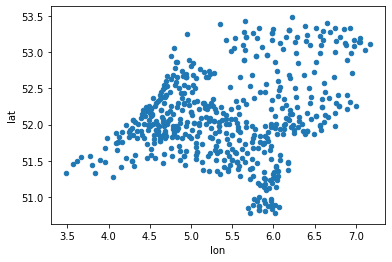

In [100]:
communes.plot.scatter('lon', 'lat')

In [108]:
fix_my_communes = {
    'Wymbritseradiel' : [52.999456, 5.578561],
    'Lemsterland' : [52.85, 5.716667],
    'Wûnseradiel' : [53.1, 5.466667],
    'Wvnseradiel' : [53.1, 5.466667],
    'Skarsterlân' : [52.966667, 5.783333],
    'Menarmeradiel' : [53.216667, 5.666667],
    'Jacobswoude' : [52.2, 4.65],
    'Harenkarspel' : [52.73, 4.75],
    'Nissewaard' : [51.8283, 4.2792],
    'SkarsterlGn' : [52.966667, 5.783333]
}

In [113]:
communes.loc[communes.lat.isna(), 'lat'] = communes.loc[communes.lat.isna(), 'commune'].map(fix_my_communes).str[0]
communes.loc[communes.lat.isna(), 'lon'] = communes.loc[communes.lon.isna(), 'commune'].map(fix_my_communes).str[1]

In [115]:
coordinates_map = {commune : {'lat' : lat, 'lon' : lon} for commune, lat, lon in zip(communes.commune, communes.lat, communes.lon)}

with open('Variables/mappers/coordinates_map_google_geocode.json', 'w') as outfile:
    json.dump(coordinates_map, outfile)

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

In [116]:
geo_points_communes = gpd.GeoDataFrame(communes, 
                                       crs = {'init' : 'epsg:4326'}, 
                                       geometry = [Point(xy) for xy in zip(communes.lon, communes.lat)])

geo_points_communes.to_file('communes_points_google.gpkg', driver = 'GPKG')

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_communes_points_google_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_communes_points_google_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


# Коммуны к коммунам 2018 г.

## Проверка кооректности геокодирования

In [9]:
with open('Variables/mappers/coordinates_map_google_geocode.json') as infile:
    coordinates_map = json.load(infile)

In [11]:
with open('communes_responses_google.json') as infile:
    responses = json.load(infile)

In [21]:
responses['Wûnseradiel']

[]

___

In [10]:
geo_points_communes = gpd.read_file('communes_points_google.gpkg')
communes_2018 = gpd.read_file('../qgis/base/Netherlands_communes.gpkg')

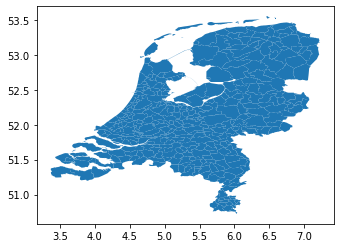

In [12]:
communes_2018.plot()

In [13]:
geo_points_communes[geo_points_communes.lon.isna()]

,commune,address,lat,lon,geometry
305,Geen aankomstpunt in Nederland,"Geen aankomstpunt in Nederland, Netherlands",NaN,NaN,POINT (nan nan)
356,0.0,"0.0, Netherlands",NaN,NaN,POINT (nan nan)


In [36]:
fix_my_communes = {
    'Wymbritseradiel' : [52.999456, 5.578561],
    'Lemsterland' : [52.85, 5.716667],
    'Wûnseradiel' : [53.1, 5.466667],
    'Wvnseradiel' : [53.1, 5.466667],
    'Skarsterlân' : [52.966667, 5.783333],
    'Menarmeradiel' : [53.216667, 5.666667],
    'Jacobswoude' : [52.2, 4.65],
    'Harenkarspel' : [52.73, 4.75],
    'Nissewaard' : [51.8283, 4.2792],
    'SkarsterlGn' : [52.966667, 5.783333]
}

In [37]:
geo_points_communes.loc[geo_points_communes.lat.isna(), 'lat'] = geo_points_communes.loc[geo_points_communes.lat.isna(), 'commune'].map(fix_my_communes).str[0]
geo_points_communes.loc[geo_points_communes.lon.isna(), 'lon'] = geo_points_communes.loc[geo_points_communes.lon.isna(), 'commune'].map(fix_my_communes).str[1]

In [38]:
geo_points_communes[geo_points_communes.lon.isna()]

,commune,address,lat,lon,geometry
305,Geen aankomstpunt in Nederland,"Geen aankomstpunt in Nederland, Netherlands",NaN,NaN,POINT (nan nan)
356,0.0,"0.0, Netherlands",NaN,NaN,POINT (nan nan)


In [43]:
geo_points_communes['lat'] = geo_points_communes['lat'].astype(float)
geo_points_communes['lon'] = geo_points_communes['lon'].astype(float)

In [44]:
geo_points_communes = gpd.GeoDataFrame(geo_points_communes, 
                                       crs = {'init' : 'epsg:4326'}, 
                                       geometry = [Point(xy) for xy in zip(geo_points_communes.lon, geo_points_communes.lat)])

geo_points_communes.to_file('communes_points_google.gpkg', driver = 'GPKG')

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_communes_points_google_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_communes_points_google_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


In [14]:
joined_communes = gpd.sjoin(communes_2018, geo_points_communes, how = 'left', op = 'intersects')
joined_communes.head()

C:\Users\mtopn\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


,NAME,POPULATION,Area,DENSITY,geometry,index_right,commune,address,lat,lon
0,Aa en Hunze,25390,279914646,90.71,(POLYGON ((6.944836772102481 52.99215596570361...,487,Aa en Hunze,"Aa en Hunze, Netherlands",53.010485,6.749528
1,Assen,67708,83621452,809.70,(POLYGON ((6.568604595030538 52.94576501347922...,102,Assen,"Assen, Netherlands",52.992753,6.564228
2,Borger-Odoorn,25351,272907572,92.89,(POLYGON ((7.020432471769706 52.87130845397606...,85,Borger-Odoorn,"Borger-Odoorn, Netherlands",52.889372,6.888404
3,Coevorden,35299,299357668,117.92,(POLYGON ((6.815015728840681 52.64786459842855...,287,Coevorden,"Coevorden, Netherlands",52.661357,6.741062
4,De Wolden,23917,226940619,105.39,(POLYGON ((6.454367764449058 52.78519798884386...,545,De Wolden,"De Wolden, Netherlands",52.681979,6.366039


In [15]:
print(len(joined_communes), len(communes_2018))

545 380


In [49]:
communes_2018['NAME'].to_excel('communes_to_russian.xlsx', index = None)

In [55]:
joined_communes = joined_communes.assign(
    lat = lambda frame: frame.geometry.centroid.y,
    lon = lambda frame: frame.geometry.centroid.x
)

In [16]:
coordinates_map = {commune : {'lat' : lat, 'lon' : lon} for commune, lat, lon in zip(communes_2018.NAME, 
                                                                                     communes_2018.geometry.centroid.y, 
                                                                                     communes_2018.geometry.centroid.x)}

with open('Variables/mappers/coordinates_map_final.json', 'w') as outfile:
    json.dump(coordinates_map, outfile)

In [57]:
names_map = dict(zip(joined_communes.commune, joined_communes.NAME))

with open('Variables/mappers/communes_names_map.json', 'w') as outfile:
    json.dump(names_map, outfile)

In [5]:
communes_to_russian = pd.read_excel('Variables/mappers/communes_to_russian.xlsx')

names_to_russian = dict(zip(communes_to_russian['NAME'], communes_to_russian['name_rus']))

with open('Variables/mappers/communes_names_toRussian_map.json', 'w') as outfile:
    json.dump(names_to_russian, outfile)

# Выделение статистики по территориям  на основании данных опроса

Опрос содержит некоторые  характеристики домохозяйств, которые являются полезными для использования в дальнейшем ходе исследования, поэтому было принято решение выделить из файлов отдельные статистические слои

In [185]:
col_subsets = {
    'sex' : 'dem_sex',
    'ageGroups' : 'dem_ageGroup',
    'occupation' : 'econ_occupation',
    'n_working_hours' : 'econ_work',
    'education' : 'social_education',
    'income_groups' : 'econ_income',
    'income_deciles' : 'econ_hh_income_deciles',
    'vehicles' : ['n_cars', 'n_bikes', 'n_motorsycles', 'n_mopeds', 'n_mopeds', 'n_other_vehicles'],
    'travel_motivation' : 'motiv_motivation',
    'trip_duration' : 'time_travel_time'
}

In [186]:
for datatype in col_subsets:
    series_list = []
    for year in datasets:
        current_dataset = datasets[year]
        columns_gr = ['geo_commune']
        
        if datatype == 'income_groups' and int(year) >= 2010:
            subset = 'econ_hh_income'
        elif datatype in ['income_deciles', 'trip_duration'] and int(year) < 2010:
            continue
        else:
            subset = col_subsets[datatype]
        
        
        if type(subset) == list:
            columns_gr = columns_gr + subset
        else:
            columns_gr.append(subset)
        series_list.append(
            current_dataset.groupby(columns_gr)['uid'].nunique()
        )
    pd.DataFrame(series_list).transpose().to_csv(f'stats_extracted/stats_{datatype}.csv')

##  Получение статистики по коммунам

CBS Open Data предоставляет довольно дробную статистику по коммунам Нидерландов вплоть до структуры экономики.

In [3]:
import cbsodata

In [4]:
datasets = {
    '2019' : '84583NED',
    '2018' : '84286NED',
    '2017' : '83765NED',
    '2016' : '83487NED',
    '2015' : '83220NED',
    '2014' : '82931NED',
    '2013' : '82339NED',
    '2009 - 2012' : '70904ned',
    '2004 - 2008' : '81903NED'
}

In [6]:
for timespan, code in datasets.items():
    print(timespan, code)

2019 84583NED
2018 84286NED
2017 83765NED
2016 83487NED
2015 83220NED
2014 82931NED
2013 82339NED
2009 - 2012 70904ned
2004 - 2008 81903NED


In [11]:
values_map = defaultdict(dict)
for year in datasets:
    
    table_id = datasets[year]
    pd.DataFrame(
        cbsodata.get_data(table_id, typed = True)
    ).to_csv(f'territory_bases_v2/database_{year}.csv', sep = ';', index = None)
    
    
    mapping_columns = {}
    list_variables = cbsodata.get_meta(table_id, 'DataProperties')
    
    for var in list_variables:
        mapping_columns[var['Key']] = var['Title']
        
    values_map[year] = mapping_columns
    print(year)

2019
2018
2017
2016
2015
2014
2013
2009 - 2017
2004 - 2008


In [12]:
with open('territory_bases_v2/map_columns.json', 'w') as outfile:
    json.dump(values_map, outfile)

In [13]:
with open('territory_bases_v2/map_columns.json') as infile:
    values_map = json.load(infile)

In [14]:
writer = pd.ExcelWriter('territory_bases_v2/map_columns.xlsx')

for year in values_map:
    pd.DataFrame(
        {'raw_name' : pd.Series(list(values_map[year].keys())),
         'name' : pd.Series(list(values_map[year].values()))}
    ).to_excel(writer, sheet_name = year, index = False)
    
writer.save()

In [20]:
pd.read_csv('territory_bases_v2/database_2004 - 2008.csv', sep = ';')['Perioden'].unique()

array([2004, 2005, 2006, 2007, 2008], dtype=int64)

### Meta Tables

In [9]:
writer = pd.ExcelWriter('territory_bases_v2/all_meta.xlsx')
for timespan, code in datasets.items():

    pd.DataFrame(cbsodata.get_meta(code, 'DataProperties')).to_excel(writer, sheet_name = timespan, index = None)
    
writer.save()

## Cоздание матриц корреспонденции между коммунами

In [3]:
datasets_list = os.listdir('translated_data/')

In [5]:
os.makedirs('analysis/correspondence_matricies/full')
os.makedirs('analysis/correspondence_matricies/consumer')
os.makedirs('analysis/correspondence_matricies/commuter')
os.makedirs('analysis/correspondence_matricies/other')

In [6]:
consumer = ['Покупки', 'Услуги', 'Туризм и рекреация', 'Другие виды досуга']
commuter = ['Работа', 'Рабочая встреча']

In [4]:
with open('Variables/mappers/communes_names_map.json') as infile:
    names_map = json.load(infile)

In [26]:
df_current = pd.read_csv(f'translated_data/{dataset}')

C:\Users\mtopn\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (7,13,18,25,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
df_current = df_current[df_current.geo_departure != df_current.geo_arrival]
df_current['geo_departure'], df_current['geo_arrival'] = df_current['geo_departure'].map(names_map), df_current['geo_arrival'].map(names_map)

correspondence = pd.pivot_table(df_current, 'uid_person', index = 'geo_departure', columns = 'geo_arrival', aggfunc = 'nunique')

In [7]:
for dataset in datasets_list:
    year = dataset.split('_')[1].split('.')[0]
    df_current = pd.read_csv(f'translated_data/{dataset}')
    
    df_current = df_current[df_current.geo_departure != df_current.geo_arrival]
    df_current['geo_departure'], df_current['geo_arrival'] = df_current['geo_departure'].map(names_map), df_current['geo_arrival'].map(names_map)
        
    correspondence = pd.pivot_table(df_current, 'uid_person', index = 'geo_departure', columns = 'geo_arrival', aggfunc = 'nunique')
    correspondence.fillna('').to_html(f'analysis/correspondence_matricies/full/corresp_full_{year}.html')
    correspondence.to_csv(f'analysis/correspondence_matricies/full/corresp_full_{year}.csv')
    
    shopping_and_services = df_current[df_current.motiv_motivation.isin(motivation_filter)]
    correspondence = pd.pivot_table(shopping_and_services, 'uid_person', index = 'geo_departure', columns = 'geo_arrival', aggfunc = 'nunique')
    correspondence.fillna('').to_html(f'analysis/correspondence_matricies/consumer/corresp_consumer_{year}.html')
    correspondence.to_csv(f'analysis/correspondence_matricies/consumer/corresp_consumer_{year}.csv')
    
    shopping_and_services = df_current[~df_current.motiv_motivation.isin(motivation_filter)]
    correspondence = pd.pivot_table(shopping_and_services, 'uid_person', index = 'geo_departure', columns = 'geo_arrival', aggfunc = 'nunique')
    correspondence.fillna('').to_html(f'analysis/correspondence_matricies/other/corresp_other_{year}.html')
    correspondence.to_csv(f'analysis/correspondence_matricies/other/corresp_other_{year}.csv')

C:\Users\mtopn\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (7,13,18,25,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
